# Publication Analysis

## Setup

### Import necessary packages

In [1]:
import requests, lxml, sys, sent2vec, nltk, cProfile

import numpy as np
import matplotlib.pyplot as plt
import bayesian_changepoint_detection.offline_changepoint_detection as offcd

from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.decomposition import PCA
from functools import partial
from wordcloud import WordCloud
from bs4 import BeautifulSoup

Use scipy logsumexp().


### Load models

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

model_path = 'biosentvec.bin'
model = sent2vec.Sent2vecModel()
model.load_model(model_path)

[nltk_data] Downloading package stopwords to /Users/dddp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dddp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Set constants

In [3]:
term = 'Dengue'

BASE_URL = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
MIN_PAPERS = 50 # minimum number of papers in a year to use for analysis
stop_words = set(stopwords.words('english'))

### Define helper functions

In [4]:
# preprocesses text before BioSentVec embedding
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

# computes Euclidean distance
def dist(x, y):
    return np.linalg.norm(x - y)

# converts a list to a comma separated values format
def list_to_csv(lst):
    ret = ''
    for i, val in enumerate(lst):
        ret += f'{val},'
    return ret[:-1]

# returns the UIDs of papers based on searching the title for a query
def get_uids(query):
    uid_list = []

    retstart = 0
    RETMAX = 100000
    
    while True:
        params = {
            'db': 'pubmed',
            'term': f'{query}[title]',
            'retmax': RETMAX,
            'retstart': retstart,
        }
        res = requests.get(f'{BASE_URL}esearch.fcgi', params)
        soup = BeautifulSoup(res.text, 'xml')
        uids = soup.find_all('Id')
        num_uids = len(uids)
        if num_uids == 0:
            print(f'Found {len(uid_list)} UIDs corresponding to {query}.')
            return uid_list
        else:
            uid_list = uid_list + [uid.text for uid in uids]
            retstart += RETMAX
            
# returns the titles, abstracts, years, and year_span of publications corresponding to input UIDs          
def get_summaries(uids):
    titles = []
    abstracts = []
    years = []

    retstart = 0
    MAX_REQUEST = 10000 # number of uids to request at a time

    sys.stdout.write(f'\rRetrieved {retstart} / {len(uids)} titles.')
    sys.stdout.flush()

    while (retstart < len(uids)):
        query_uids = uids[retstart:retstart + MAX_REQUEST]
        params = {
        'db': 'pubmed',
        'id': list_to_csv(query_uids),
        'retmax': MAX_REQUEST,
        'retmode': 'xml',
        'rettyle': 'abstract,'
        }
        res = requests.post(f'{BASE_URL}efetch.fcgi', params)
        soup = BeautifulSoup(res.text, 'xml')

        soup_articles = soup.find_all('PubmedArticle')

        for soup_article in soup_articles:
            soup_title = soup_article.find('ArticleTitle')
            soup_date = soup_article.find('PubDate')
            soup_abstract = soup_article.find('AbstractText')

            if soup_title is None or soup_date is None or soup_abstract is None or soup_date.find('Year') is None:
                continue

            titles.append(soup_title.text.replace('\xa0', ' ').replace('<i>', '').replace('</i>', ''))
            years.append(int(soup_date.find('Year').text))
            abstracts.append(soup_abstract.text)

        retstart += MAX_REQUEST

        sys.stdout.write(f'\rRetrieved {min(retstart, len(uids))} / {len(uids)} summaries.')
        sys.stdout.flush()

    titles, abstracts, years = np.array(titles), np.array(abstracts), np.array(years)
    
    titles = titles[~np.isnan(years)]
    abstracts = abstracts[~np.isnan(years)]
    years = years[~np.isnan(years)]
    
    titles_mod, abstracts_mod, years_mod = [], [], []
    
    for title, abstract, year in zip(titles, abstracts, years):
        if len(years[years == year]) >= MIN_PAPERS:
            titles_mod.append(title)
            abstracts_mod.append(abstract)
            years_mod.append(year)
            
    titles, abstracts, years = np.array(titles_mod), np.array(abstracts_mod), np.array(years_mod)
    
    year_span = np.unique(years)

    print(f'\nAfter filtering, retrieved {len(titles)} summaries.')
        
    return titles, abstracts, years, year_span

def get_titles_and_abstracts_and_years(term):
    return get_summaries(get_uids(term))

### Load publication data from NCBI

In [5]:
titles, abstracts, years, year_span = get_titles_and_abstracts_and_years(term)

Found 15251 UIDs corresponding to Dengue.
Retrieved 15251 / 15251 summaries.
After filtering, retrieved 11528 summaries.


## Publication Analysis

### Number of publications vs time

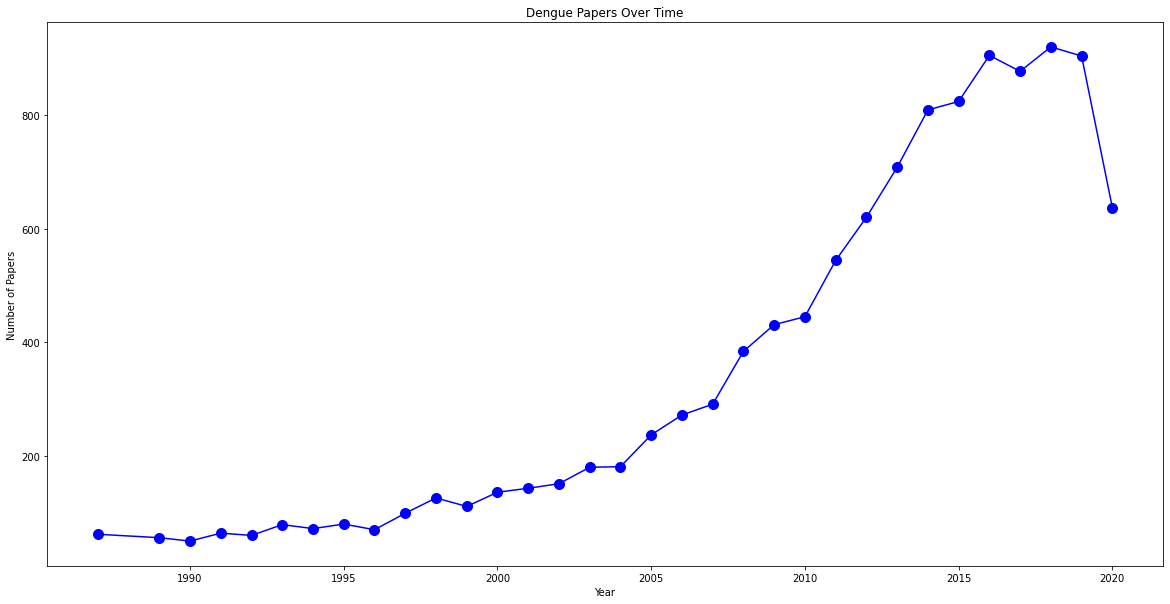

In [6]:
num_papers = [np.sum(years == year) for year in year_span]

fig = plt.figure(figsize=(20, 10))
plt.title(f'{term} Papers Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.plot(year_span, num_papers, color='b')
plt.scatter(year_span, num_papers, color='b', s=100)
plt.rc('font', size=20)
plt.show()

### Title length vs time

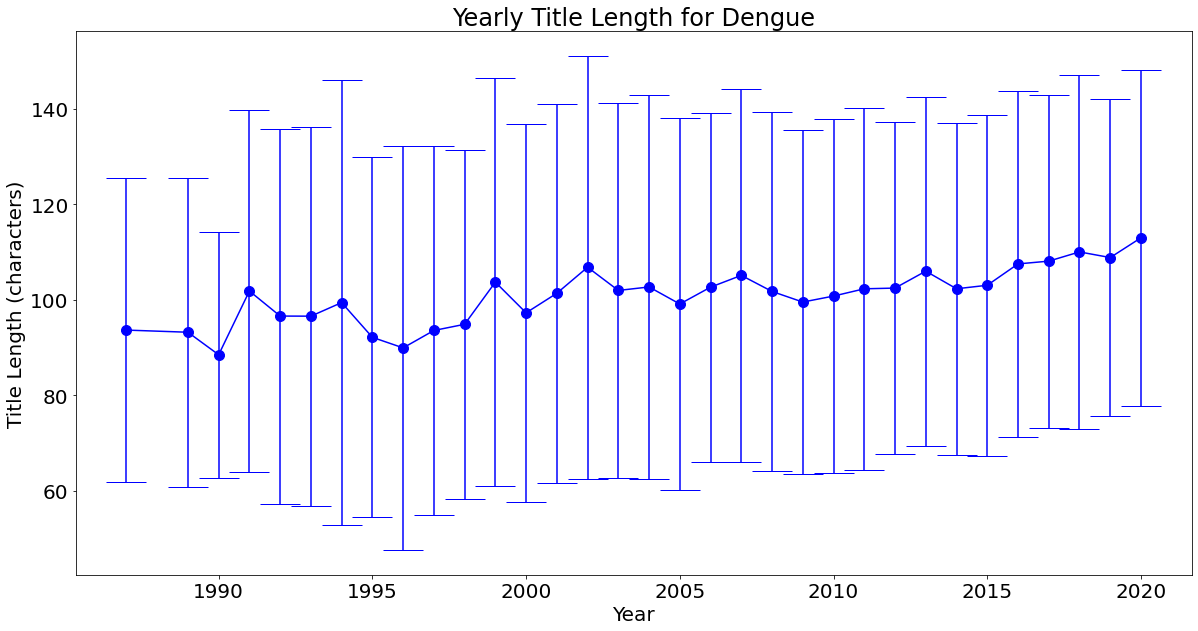

In [7]:
lengths = np.array([len(title) for title in titles])
average_lengths = [np.mean(lengths[years == year]) for year in year_span]
stdev_lengths = [np.std(lengths[years == year]) for year in year_span]

plt.figure(figsize=(20, 10))
plt.scatter(year_span, average_lengths, color='b', s=100)
plt.plot(year_span, average_lengths, color='b')
plt.errorbar(year_span, average_lengths, yerr=stdev_lengths, fmt='none', color='b', capsize=20)
plt.title(f'Yearly Title Length for {term}')
plt.xlabel('Year')
plt.ylabel('Title Length (characters)')
plt.rc('font', size=20)
plt.show()

### Title entropies vs time

/Users/dddp/Documents/TemporalLandscape/env_TemporalLandscape/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


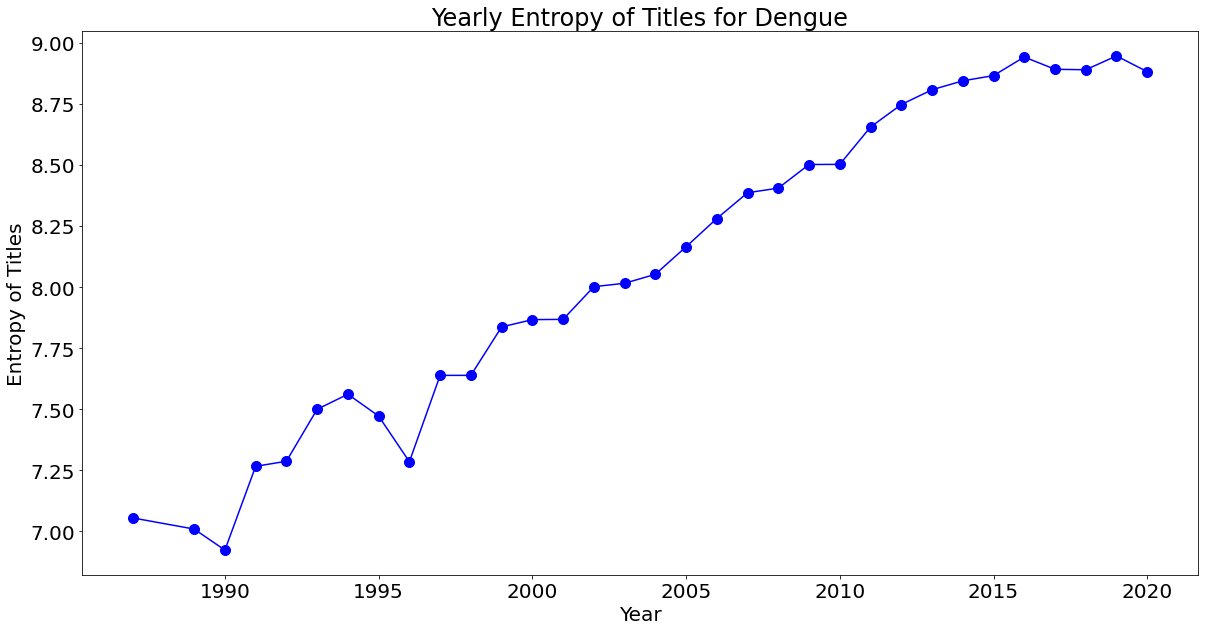

In [8]:
vectorizer = CountVectorizer()
v = vectorizer.fit_transform(titles).toarray()
frequencies_unsorted = np.sum(v, axis=0)
features_unsorted = vectorizer.get_feature_names()
features, frequencies = zip(*sorted(zip(features_unsorted, frequencies_unsorted), key=lambda f: -f[1]))

probabilities = []

for year in year_span:
    t = v[years == year]
    probabilities.append(np.sum(t, axis=0) / np.sum(np.sum(t, axis=0)))

entropies = [-np.sum(np.multiply(probability, np.nan_to_num(np.log2(probability), neginf=0))) for probability in probabilities]

plt.figure(figsize=(20, 10))
plt.plot(year_span, entropies, color='b')
plt.scatter(year_span, entropies, color='b', s=100)
plt.title(f'Yearly Entropy of Titles for {term}')
plt.xlabel('Year')
plt.ylabel('Entropy of Titles')
plt.rc('font', size=20)
plt.show()

### Most common words in publication titles

In [9]:
num_plot = 40

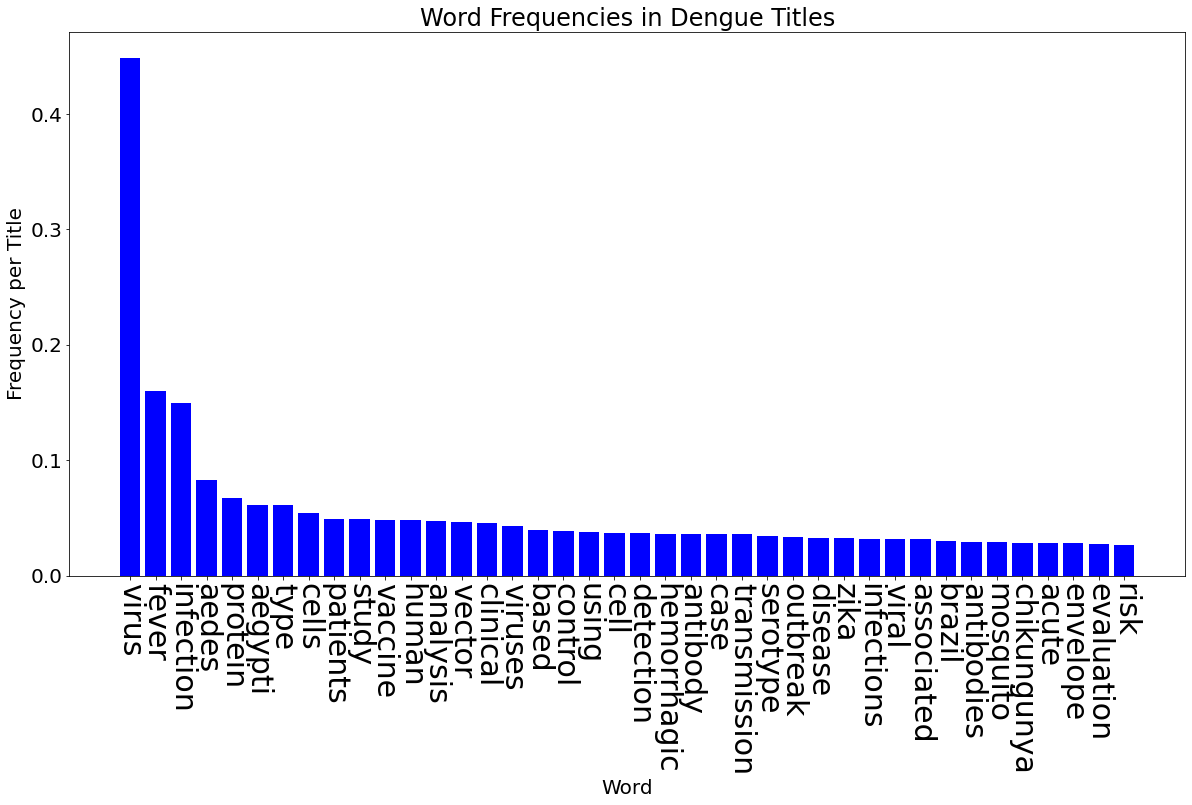

In [10]:
frequencies_per_title = np.divide(frequencies, len(years))

frequencies_plot, features_plot = [], []
for frequency, feature in zip(frequencies_per_title, features):
    if feature not in stop_words:
        frequencies_plot.append(frequency)
        features_plot.append(feature)

fig = plt.figure(figsize=(20, 10))
plt.title(f'Word Frequencies in {term} Titles')
plt.xlabel('Word')
plt.ylabel('Frequency per Title')
plt.bar(range(num_plot), frequencies_plot[1:num_plot+1], color='b')
plt.xticks(range(num_plot), features_plot[1:num_plot+1])
plt.setp(plt.gca().get_xticklabels(), rotation=-90, size=30)
plt.rc('font', size=20)
plt.show()

### Word frequency changepoint analysis in publication titles

In [11]:
# only consider words whose average title frequency is at least FREQUENCY_THRESHOLD
FREQUENCY_THRESHOLD = 0.05

# only consider words with a changepoint probability of at least PROBABILITY_THRESHOLD
PROBABILITY_THRESHOLD = 0.5

In [12]:
word_distributions = []
for year in year_span:
    t = v[years == year]
    word_distributions.append(np.sum(t, axis=0) / np.sum(years == year))
word_distributions = np.transpose(word_distributions)

for feature in features:
    if np.mean(word_distributions[features_unsorted.index(feature)]) < FREQUENCY_THRESHOLD:
        break
    
    data_unnormalized = word_distributions[features_unsorted.index(feature)]
    
    data = []
    for i, year in enumerate(year_span):
        if data_unnormalized[i] == 0:
            data.append(0)
        else:
            data.append(data_unnormalized[i] / np.max(data_unnormalized) * 100)
    data = np.array(data)
    
    Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)
    probs = np.exp(Pcp).sum(0)
    
    if np.max(probs) < PROBABILITY_THRESHOLD:
        continue
    
    plt.figure(figsize=(20, 20))
    plt.subplot(211)
    plt.plot(year_span, word_distributions[features_unsorted.index(feature)], color='b')
    plt.scatter(year_span, word_distributions[features_unsorted.index(feature)], color='b', s=100)
    plt.title(f'Word Frequency Per Title for {term}: {feature}')
    plt.xlabel('Year')
    plt.ylabel('Frequency Per Title')
    plt.rc('font', size=20)
    
    plt.subplot(212)
    plt.title(f'Changepoint Analysis for {term}: {feature}')
    plt.xlabel('Year')
    plt.ylabel('Changepoint Probability')
    plt.plot(year_span[1:], probs, color='r')
    plt.scatter(year_span[1:], probs, color='r', s=100)
    plt.rc('font', size=20)
    plt.show()

### Generate title vectors with BioSentVec

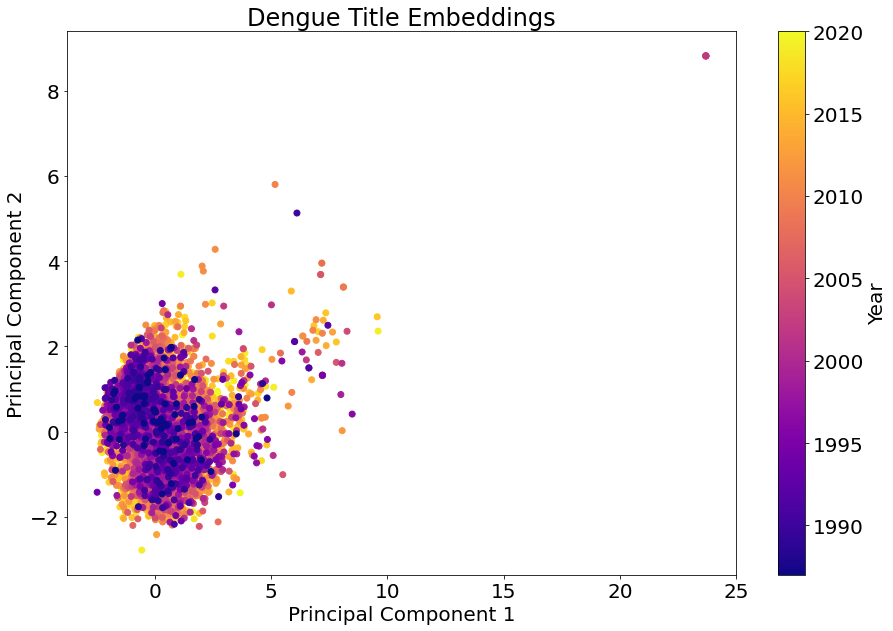

In [13]:
titles_processed = [preprocess_sentence(title) for title in titles]
title_vectors = model.embed_sentences(titles_processed)
titles_reduced = PCA(n_components=2).fit_transform(title_vectors)

plt.figure(figsize=(15, 10))
plt.scatter(titles_reduced.T[0], titles_reduced.T[1], c=years, cmap='plasma')
plt.title(f'{term} Title Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.rc('font', size=20)
plt.colorbar().set_label('Year', rotation=90)
plt.show()

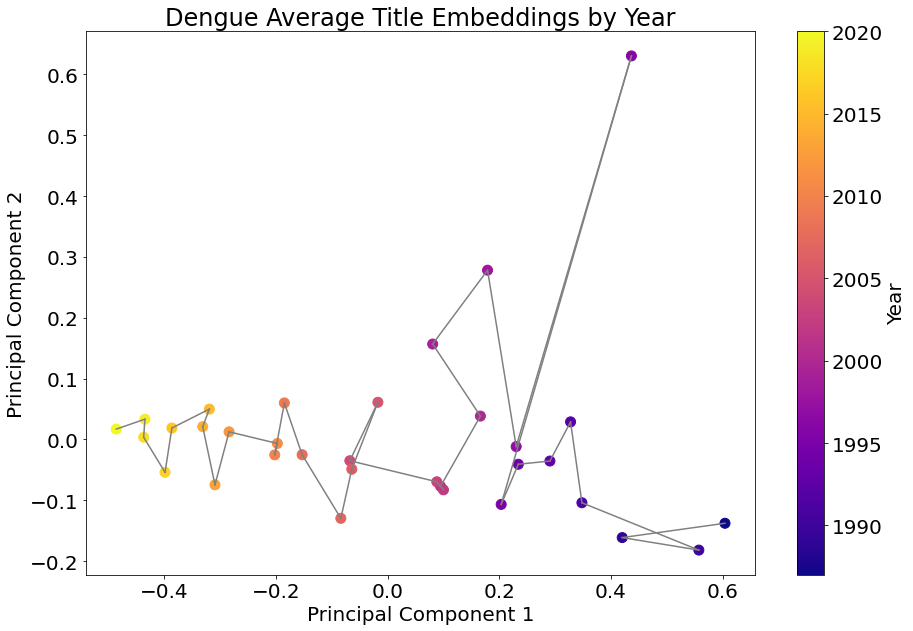

In [14]:
titles_span = np.array([np.mean(title_vectors[years == year], axis=0) for year in year_span])
titles_span_reduced = PCA(n_components=2).fit_transform(titles_span)

plt.figure(figsize=(15, 10))
plt.scatter(titles_span_reduced.T[0], titles_span_reduced.T[1], c=year_span, cmap='plasma', s=100)
plt.title(f'{term} Average Title Embeddings by Year')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar().set_label('Year', rotation=90)

plot_1 = titles_span_reduced[:-1]
plot_2 = titles_span_reduced[1:]
for i, p1 in enumerate(plot_1):
    p2 = plot_2[i]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray')

plt.rc('font', size=20)
plt.show()

### Identify research trends by identifying the paper titles with embeddings closest to the mean for each year

In [15]:
# number of representative papers to list closest to the mean
NUMBER_OF_PAPERS = 5

In [16]:
for title_mean, year in zip(titles_span, year_span):
    titles_mod = titles[year == years]
    title_vectors_mod = title_vectors[year == years]
    ds = [dist(title_mean, t_v) for t_v in title_vectors_mod]
    ds_sorted, titles_sorted = zip(*sorted(zip(ds, titles_mod), key=lambda x: x[0]))
    print(f'Year: {year}')
    print()
    for i in range(NUMBER_OF_PAPERS):
        try:
            print(f'Distance to mean: {ds_sorted[i]}')
            print(f'Title: {titles_sorted[i]}')
            print()
        except:
            break

Year: 1987

Distance to mean: 2.447877883911133
Title: The status of dengue fever virus in South Africa--serological studies and diagnosis of a case of dengue fever.

Distance to mean: 2.6162936687469482
Title: Disease severity-related antigenic differences in dengue 2 strains detected by dengue 4 monoclonal antibodies.

Distance to mean: 2.626601219177246
Title: Study of the distribution of antibody-dependent enhancement determinants on dengue 2 isolates using dengue 2-derived monoclonal antibodies.

Distance to mean: 2.706205368041992
Title: Dengue 4 virus monoclonal antibodies identify epitopes that mediate immune infection enhancement of dengue 2 viruses.

Distance to mean: 2.869065284729004
Title: Multiplication and distribution of type 2 dengue and Japanese encephalitis viruses in Toxorhynchites splendens after intrathoracic inoculation.

Year: 1989

Distance to mean: 2.713618278503418
Title: Antibody-dependent enhancement of dengue virus growth in human monocytes as a risk facto

### Quantify novelty of each year by the proportion of papers whose title embeddings are far from previous years' title embeddings

In [17]:
# threshold distance to consider a paper to be novel
CUTOFF_DISTANCE = 5

In [18]:
year = year_span[0]

titles_prev = titles[years == year]
title_vectors_prev = title_vectors[years == year]
years_prev = years[years == year]

counts = []

for year in year_span[1:]:
    titles_curr = titles[years == year]
    title_vectors_curr = title_vectors[years == year]
    years_curr = years[years == year]
    
    ds = []
    titles_r, years_r = [], []
    
    count = 0.0
    
    for (title_curr, title_vector_curr, year_curr) in zip(titles_curr, title_vectors_curr, years_curr):
        min_distance = np.inf
        title_min, title_vector_min, year_min = None, None, None
        title_rmin, title_vector_rmin, year_rmin = None, None, None
        for (title_prev, title_vector_prev, year_prev) in zip(titles_prev, title_vectors_prev, years_prev):
            if dist(title_vector_curr, title_vector_prev) < min_distance:
                min_distance = dist(title_vector_curr, title_vector_prev)
                title_min, title_vector_min, year_min = title_curr, title_vector_curr, year_curr
                title_rmin, title_vector_rmin, year_rmin = title_prev, title_vector_prev, year_prev
                
        ds.append(min_distance)
        titles_r.append(title_rmin)
        years_r.append(year_rmin)
        
        if min_distance > CUTOFF_DISTANCE:
            count += 1
                
    ds_sorted, titles_r_sorted, years_r_sorted, titles_curr_sorted = zip(*sorted(zip(ds, titles_r, years_r, titles_curr), key=lambda x: -x[0]))
                                    
    titles_prev = np.concatenate((titles_prev, titles_curr))
    title_vectors_prev = np.concatenate((title_vectors_prev, title_vectors_curr))
    years_prev = np.concatenate((years_prev, years_curr))
    
    counts.append(count / len(years_curr))

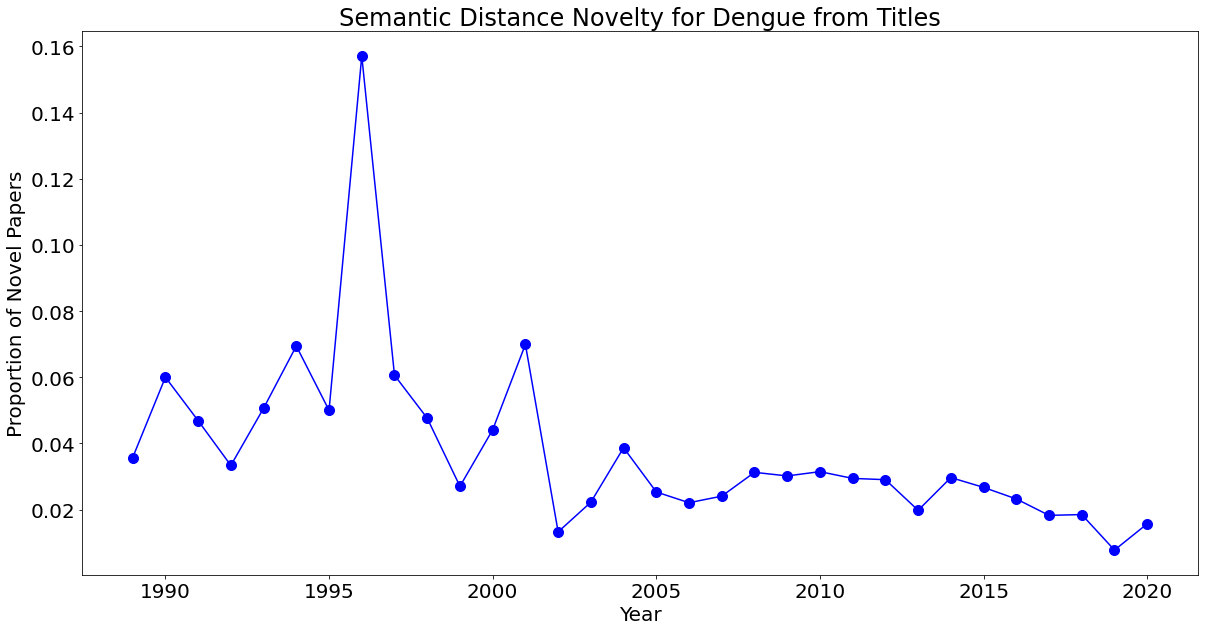

In [19]:
plt.figure(figsize=(20, 10))
plt.scatter(year_span[1:], counts, color='b', s=100)
plt.plot(year_span[1:], counts, color='b')
plt.title(f'Semantic Distance Novelty for {term} from Titles')
plt.xlabel('Year')
plt.ylabel('Proportion of Novel Papers')
plt.rc('font', size=20)
plt.show()

### Identify clusters of novel research based on paper titles

In [20]:
# identify research papers published between year CHANGEPOINT and CHANGEPOINT + DELTA,  such that
# (the mean distance between the paper title and its K nearest neighbors published before CHANGEPOINT)
# is at least RATIO_THRESHOLD times (the mean distance between the paper title and its K nearest neighbors
# also published between CHANGEPOINT and CHANGEPOINT + DELTA)
CHANGEPOINT = 2000
K = 3
DELTA = 5
RATIO_THRESHOLD = 1.2

In [21]:
titles_old, title_vectors_old, years_old = [], [], []
titles_new, title_vectors_new, years_new = [], [], []

for title, title_vector, year in zip(titles, title_vectors, years):
    if year < CHANGEPOINT:
        titles_old.append(title)
        title_vectors_old.append(title_vector)
        years_old.append(year)
    if year >= CHANGEPOINT and year <= CHANGEPOINT + DELTA:
        titles_new.append(title)
        title_vectors_new.append(title_vector)
        years_new.append(year)
            
for title, title_vector, year in zip(titles_new, title_vectors_new, years_new):
    new_distance = np.mean(sorted([dist(title_vector, t_v) for t_v in title_vectors_new])[1:][:K])
    old_distance = np.mean(sorted([dist(title_vector, t_v) for t_v in title_vectors_old])[:K])
    
    if (old_distance / new_distance) > RATIO_THRESHOLD:
        print(f'Year: {year}')
        print(f'Ratio: {old_distance / new_distance}')
        print(f'New Distance: {new_distance}')
        print(f'Old Distance: {old_distance}')
        print(f'Title: {title}')
        print()

Year: 2005
Ratio: 1.2052217721939087
New Distance: 2.3662469387054443
Old Distance: 2.8518524169921875
Title: Detection of dengue virus serotype 3 by reverse transcription-polymerase chain reaction in Aedes aegypti (Diptera, Culicidae) captured in Manaus, Amazonas.

Year: 2005
Ratio: 1.2099249362945557
New Distance: 4.040247917175293
Old Distance: 4.888396739959717
Title: [Ocular complications of dengue fever].

Year: 2005
Ratio: 1.3647780418395996
New Distance: 2.6043689250946045
Old Distance: 3.5543854236602783
Title: [Study on dengue virus infection of human dendritic cells].

Year: 2005
Ratio: 1.2462499141693115
New Distance: 3.182737350463867
Old Distance: 3.9664859771728516
Title: Dengue virus type 3, Brazil, 2002.

Year: 2005
Ratio: 1.2247074842453003
New Distance: 2.6786012649536133
Old Distance: 3.280503034591675
Title: Quantitative trait loci that control dengue-2 virus dissemination in the mosquito Aedes aegypti.

Year: 2004
Ratio: 1.8007878065109253
New Distance: 2.29420495

### Create differential wordclouds for paper titles

In [22]:
# creates a differential wordcloud for words appearing in year2, vs all words appearing before or during year1
def create_wordcloud(year1, year2):
    freqs_prev = np.sum(v[years <= year1], axis=0) / np.sum(years <= year1)
    freqs_new = np.sum(v[years == year2], axis=0) / np.sum(years == year2)

    diffs = np.subtract(freqs_prev, freqs_new)

    pos_features, neg_features = set(), set()

    d = {}
    for diff, feature in zip(diffs, features_unsorted):
        if feature in stop_words:
            continue

        diff = round(diff * 1000)
        if diff > 0:
            d[feature] = diff
            pos_features.add(feature)
        if diff < 0:
            neg_features.add(feature) 
            d[feature] = -diff

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word in pos_features:
            return "rgb(0, 0, 0)"
        if word in neg_features:
            return "rgb(256, 0, 0)"

    wordcloud = WordCloud(background_color='white', height=500, width=1000)
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3),
               interpolation="bilinear")
    plt.axis("off")
    plt.show()

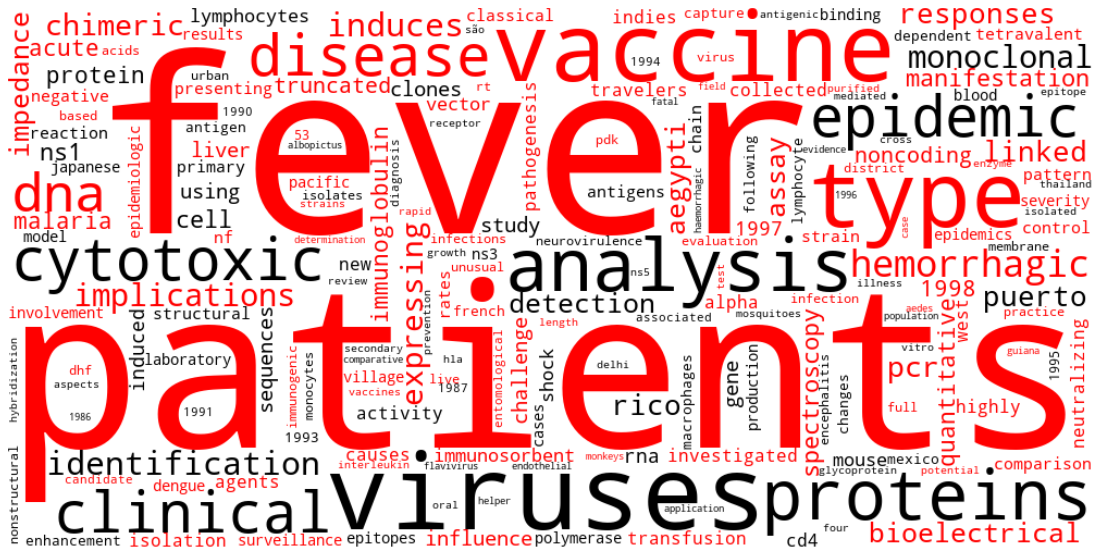

In [23]:
create_wordcloud(1999, 2000)

### Abstract length vs time

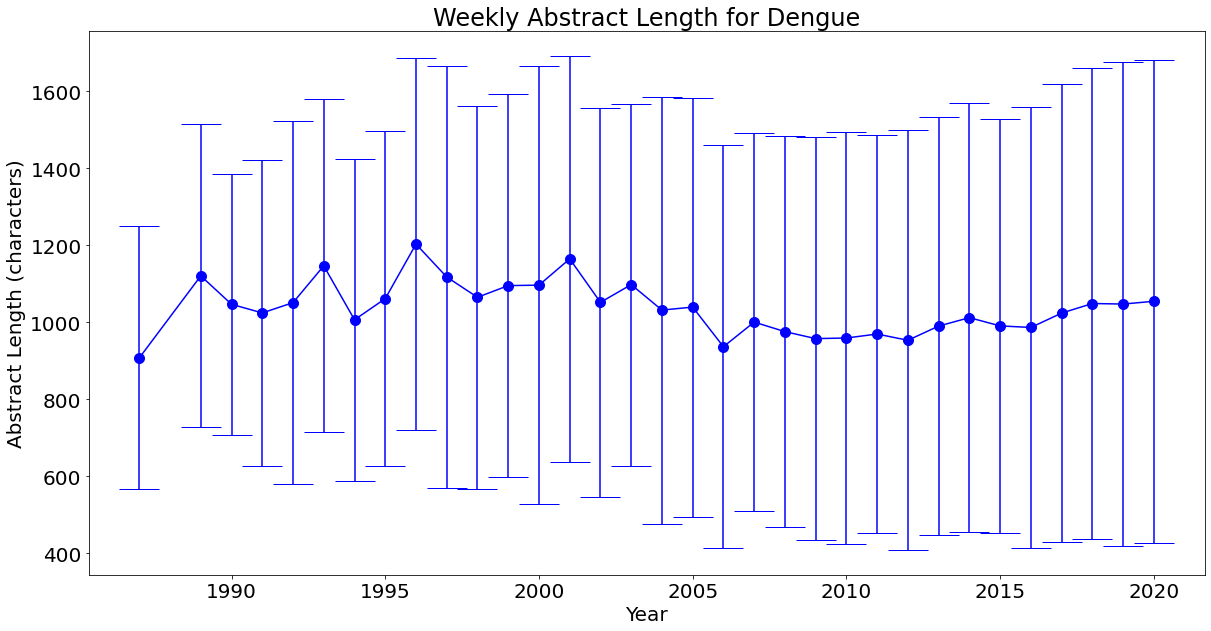

In [24]:
lengths = np.array([len(abstract) for abstract in abstracts])
average_lengths = [np.mean(lengths[years == year]) for year in year_span]
stdev_lengths = [np.std(lengths[years == year]) for year in year_span]

plt.figure(figsize=(20, 10))
plt.scatter(year_span, average_lengths, color='b', s=100)
plt.plot(year_span, average_lengths, color='b')
plt.errorbar(year_span, average_lengths, yerr=stdev_lengths, fmt='none', color='b', capsize=20)
plt.title(f'Weekly Abstract Length for {term}')
plt.xlabel('Year')
plt.ylabel('Abstract Length (characters)')
plt.rc('font', size=20)
plt.show()

### Abstract entropies vs time

/Users/dddp/Documents/TemporalLandscape/env_TemporalLandscape/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


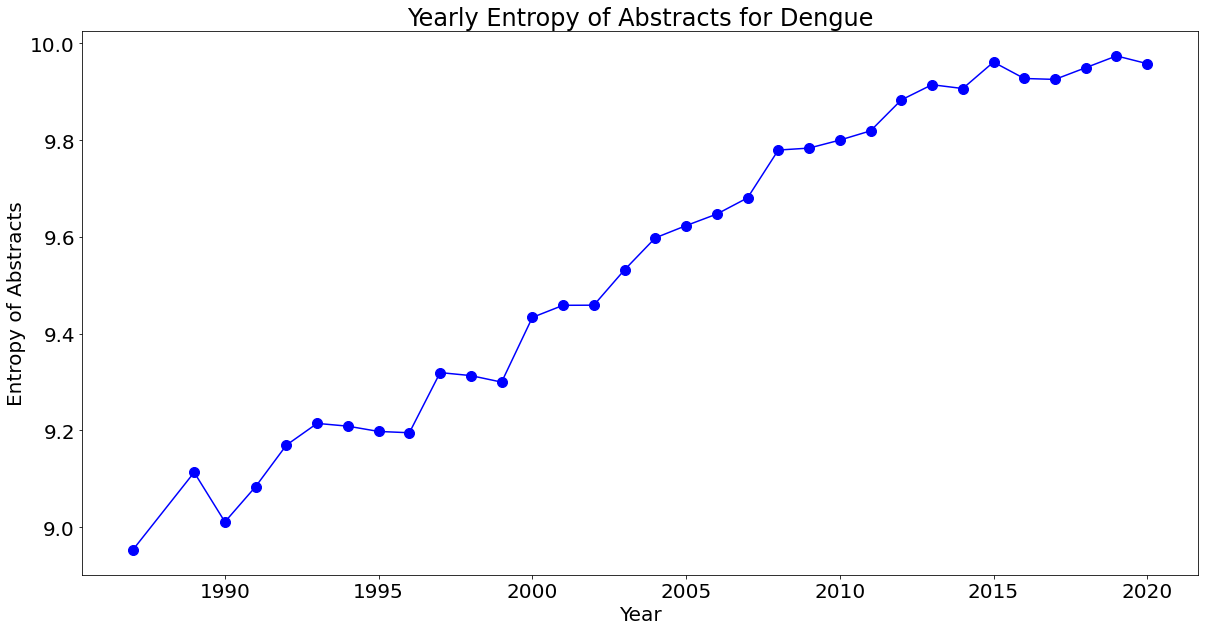

In [25]:
vectorizer = CountVectorizer()
v = vectorizer.fit_transform(abstracts).toarray()
frequencies_unsorted = np.sum(v, axis=0)
features_unsorted = vectorizer.get_feature_names()
features, frequencies = zip(*sorted(zip(features_unsorted, frequencies_unsorted), key=lambda f: -f[1]))

probabilities = []

for year in year_span:
    t = v[years == year]
    probabilities.append(np.sum(t, axis=0) / np.sum(np.sum(t, axis=0)))

entropies = [-np.sum(np.multiply(probability, np.nan_to_num(np.log2(probability), neginf=0))) for probability in probabilities]

plt.figure(figsize=(20, 10))
plt.plot(year_span, entropies, color='b')
plt.scatter(year_span, entropies, color='b', s=100)
plt.title(f'Yearly Entropy of Abstracts for {term}')
plt.xlabel('Year')
plt.ylabel('Entropy of Abstracts')
plt.rc('font', size=20)
plt.show()

### Most common words in abstracts

In [26]:
num_plot = 40

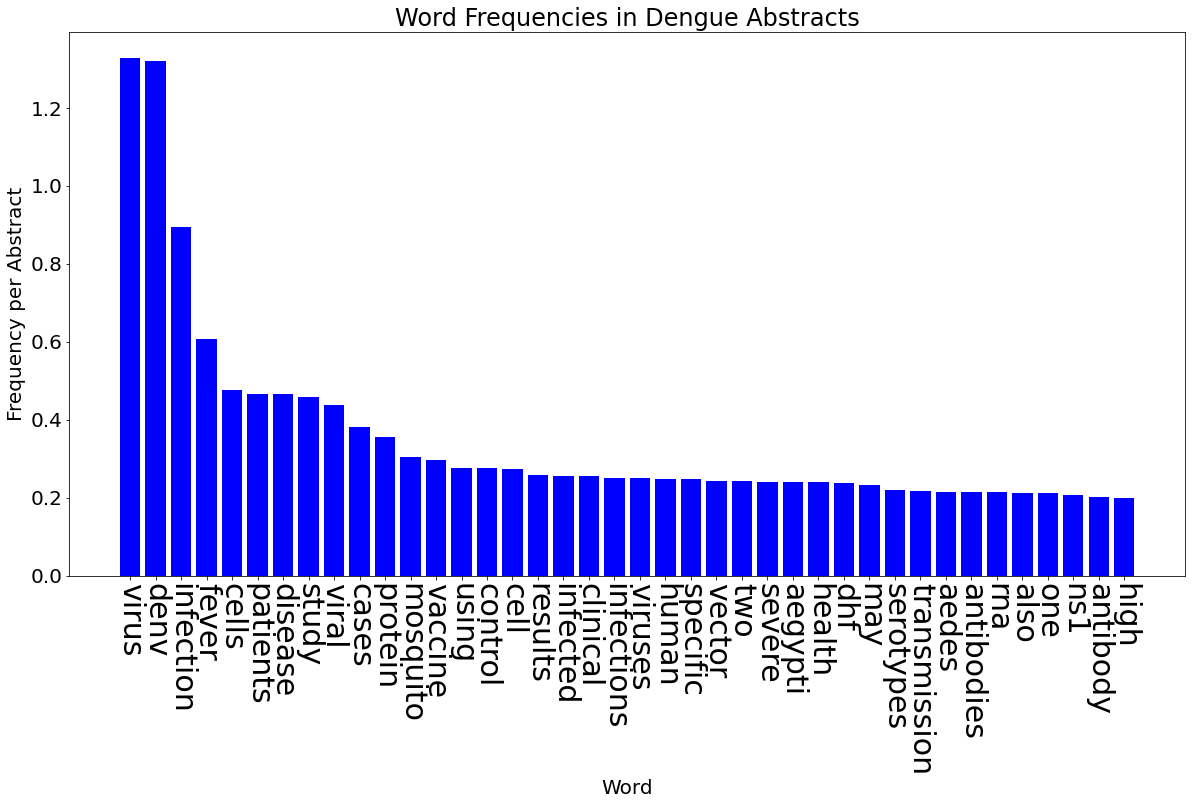

In [27]:
frequencies_per_abstract = np.divide(frequencies, len(years))

frequencies_plot, features_plot = [], []
for frequency, feature in zip(frequencies_per_abstract, features):
    if feature not in stop_words:
        frequencies_plot.append(frequency)
        features_plot.append(feature)

fig = plt.figure(figsize=(20, 10))
plt.title(f'Word Frequencies in {term} Abstracts')
plt.xlabel('Word')
plt.ylabel('Frequency per Abstract')
plt.bar(range(num_plot), frequencies_plot[1:num_plot+1], color='b')
plt.xticks(range(num_plot), features_plot[1:num_plot+1])
plt.setp(plt.gca().get_xticklabels(), rotation=-90, size=30)
plt.rc('font', size=20)
plt.show()

### Word frequency changepoint analysis in publication abstracts

In [28]:
# only consider words whose average abstract frequency is at least FREQUENCY_THRESHOLD
FREQUENCY_THRESHOLD = 0.05

# only consider words with a changepoint probability of at least PROBABILITY_THRESHOLD
PROBABILITY_THRESHOLD = 0.8

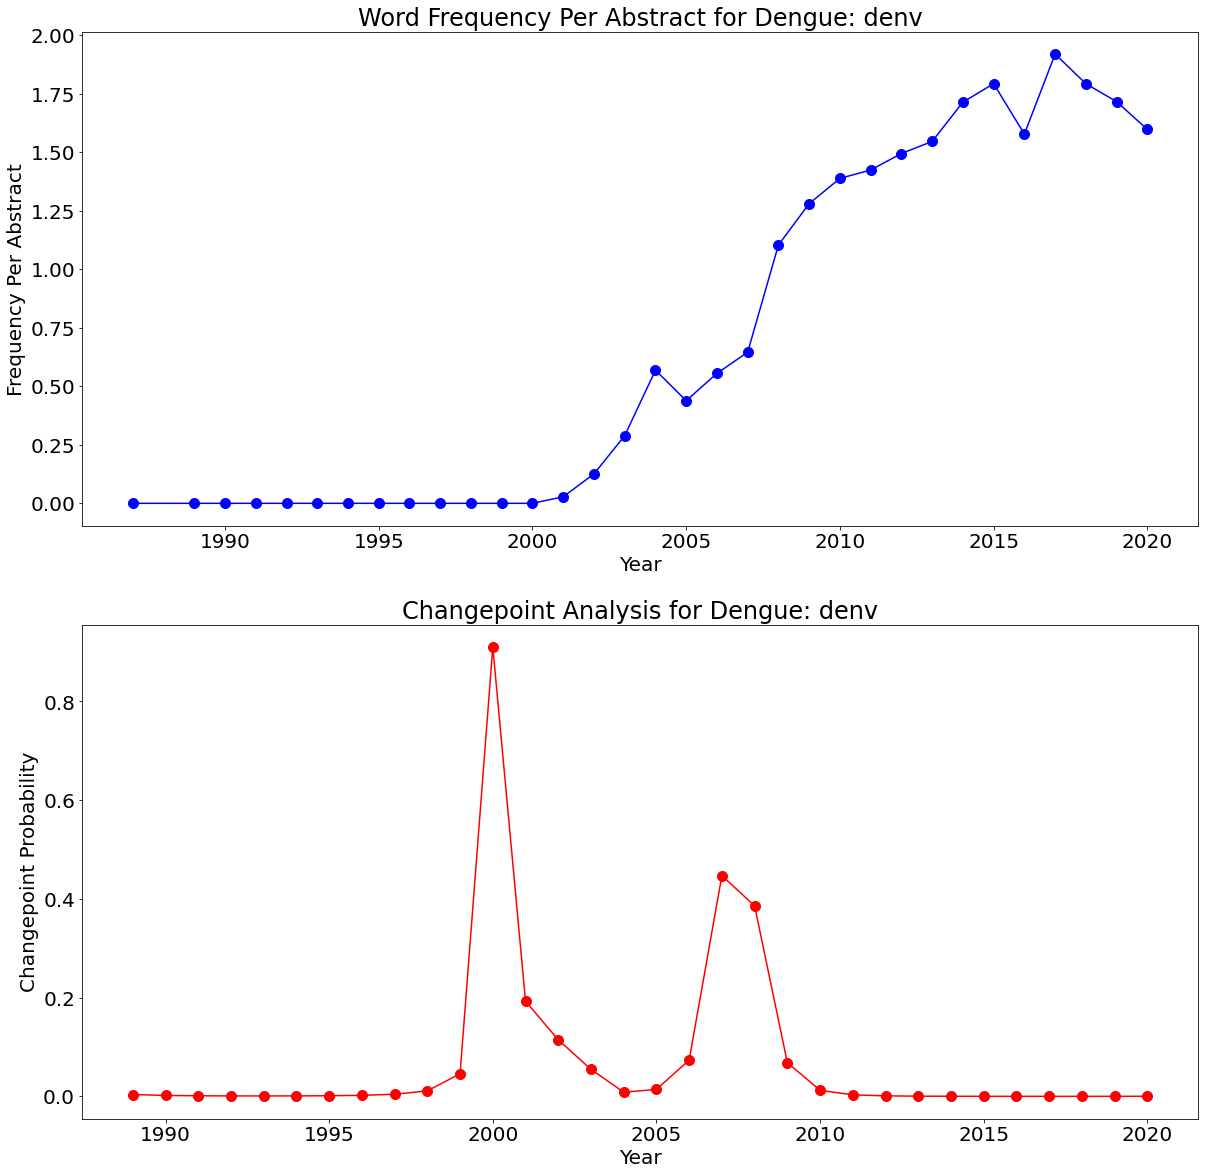

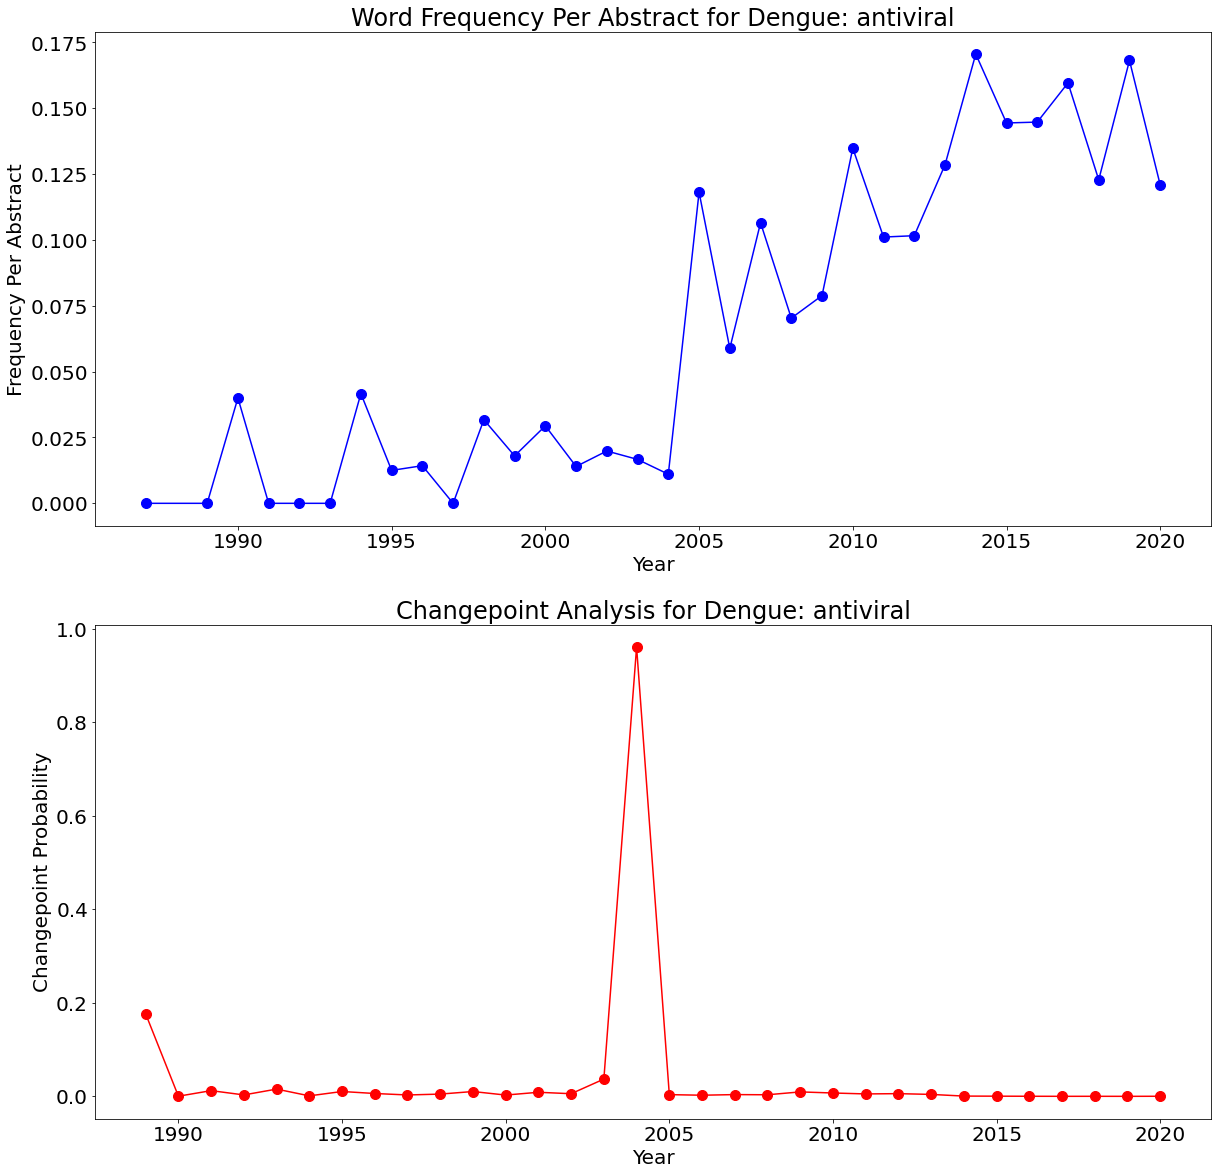

In [29]:
word_distributions = []
for year in year_span:
    t = v[years == year]
    word_distributions.append(np.sum(t, axis=0) / np.sum(years == year))
word_distributions = np.transpose(word_distributions)

for feature in features:
    if np.mean(word_distributions[features_unsorted.index(feature)]) < FREQUENCY_THRESHOLD:
        break
    
    data_unnormalized = word_distributions[features_unsorted.index(feature)]
    
    data = []
    for i, year in enumerate(year_span):
        if data_unnormalized[i] == 0:
            data.append(0)
        else:
            data.append(data_unnormalized[i] / np.max(data_unnormalized) * 100)
    data = np.array(data)
    
    Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)
    probs = np.exp(Pcp).sum(0)
    
    if np.max(probs) < PROBABILITY_THRESHOLD:
        continue
    
    plt.figure(figsize=(20, 20))
    plt.subplot(211)
    plt.plot(year_span, word_distributions[features_unsorted.index(feature)], color='b')
    plt.scatter(year_span, word_distributions[features_unsorted.index(feature)], color='b', s=100)
    plt.title(f'Word Frequency Per Abstract for {term}: {feature}')
    plt.xlabel('Year')
    plt.ylabel('Frequency Per Abstract')
    plt.rc('font', size=20)
    
    plt.subplot(212)
    plt.title(f'Changepoint Analysis for {term}: {feature}')
    plt.xlabel('Year')
    plt.ylabel('Changepoint Probability')
    plt.plot(year_span[1:], probs, color='r')
    plt.scatter(year_span[1:], probs, color='r', s=100)
    plt.rc('font', size=20)
    plt.show()

### Generate abstract vectors with BioSentVec

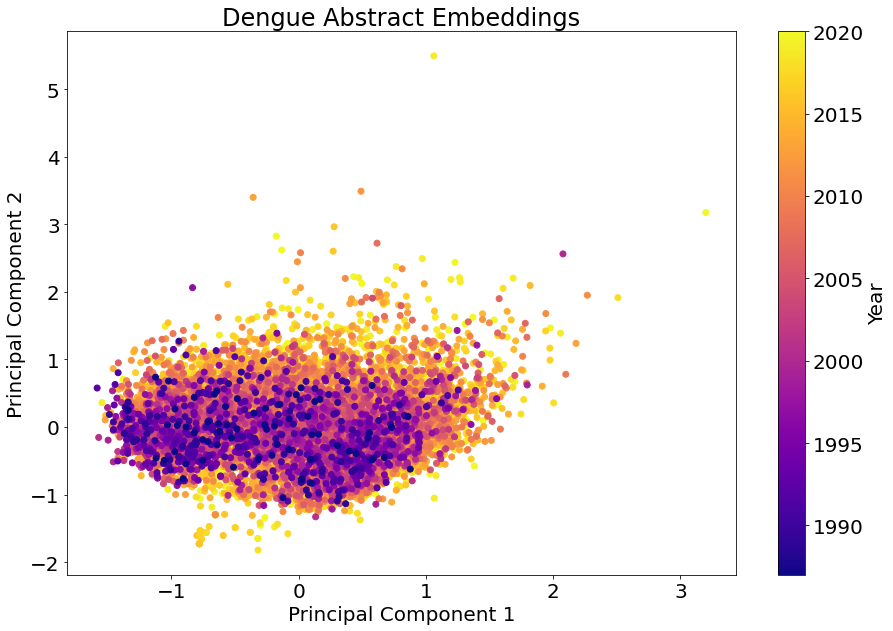

In [30]:
abstracts_processed = [preprocess_sentence(abstract) for abstract in abstracts]
abstract_vectors = model.embed_sentences(abstracts_processed)
abstracts_reduced = PCA(n_components=2).fit_transform(abstract_vectors)

plt.figure(figsize=(15, 10))
plt.scatter(abstracts_reduced.T[0], abstracts_reduced.T[1], c=years, cmap='plasma')
plt.title(f'{term} Abstract Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.rc('font', size=20)
plt.colorbar().set_label('Year', rotation=90)
plt.show()

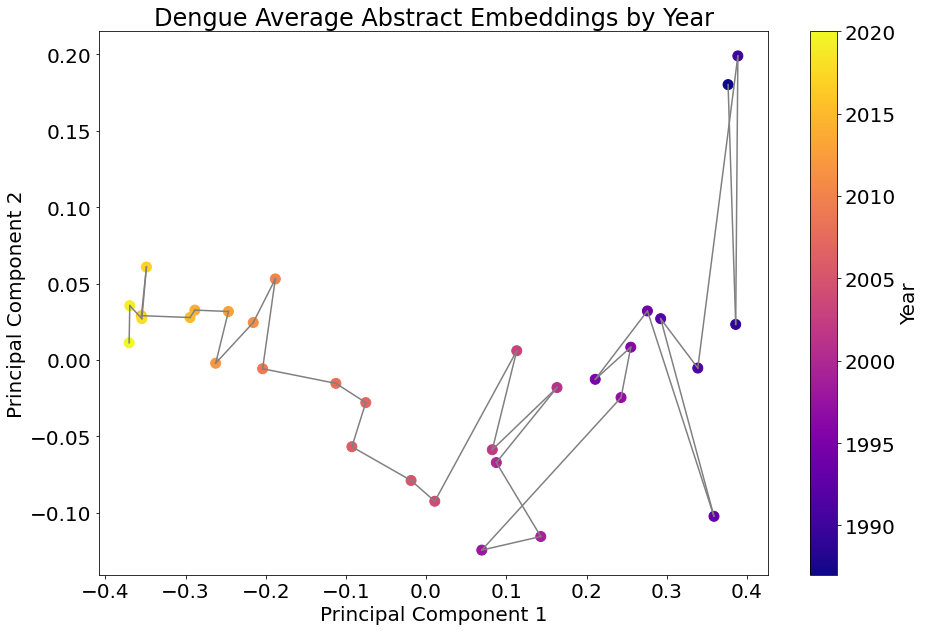

In [31]:
abstracts_span = np.array([np.mean(abstract_vectors[years == year], axis=0) for year in year_span])
abstracts_span_reduced = PCA(n_components=2).fit_transform(abstracts_span)

plt.figure(figsize=(15, 10))
plt.scatter(abstracts_span_reduced.T[0], abstracts_span_reduced.T[1], c=year_span, cmap='plasma', s=100)
plt.title(f'{term} Average Abstract Embeddings by Year')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar().set_label('Year', rotation=90)

plot_1 = abstracts_span_reduced[:-1]
plot_2 = abstracts_span_reduced[1:]
for i, p1 in enumerate(plot_1):
    p2 = plot_2[i]
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray')

plt.rc('font', size=20)
plt.show()

### Identify research trends by identifying the paper abstracts with embeddings closest to the mean for each year

In [32]:
# number of representative papers to list closest to the mean
NUMBER_OF_PAPERS = 5

In [33]:
for abstract_mean, year in zip(abstracts_span, year_span):
    abstracts_mod = abstracts[year == years]
    titles_mod = titles[year == years]
    abstract_vectors_mod = abstract_vectors[year == years]
    ds = [dist(abstract_mean, t_v) for t_v in abstract_vectors_mod]
    ds_sorted, abstracts_sorted, titles_sorted = zip(*sorted(zip(ds, abstracts_mod, titles_mod), key=lambda x: x[0]))
    print(f'Year: {year}')
    print()
    for i in range(NUMBER_OF_PAPERS):
        try:
            print(f'Distance to mean: {ds_sorted[i]}')
            print(f'Title: {titles_sorted[i]}')
            print()
        except:
            break

Year: 1987

Distance to mean: 1.389427900314331
Title: Studies into the immunopathogenesis and laboratory diagnosis of dengue haemorrhagic fever.

Distance to mean: 1.3970098495483398
Title: Immunization with a live attenuated dengue-2-virus candidate vaccine (16681-PDK 53): clinical, immunological and biological responses in adult volunteers.

Distance to mean: 1.4104970693588257
Title: Outbreak of febrile illness due to dengue virus type 3 in Calcutta during 1983.

Distance to mean: 1.428335428237915
Title: Detection of dengue virus RNA using nucleic acid hybridization.

Distance to mean: 1.4803956747055054
Title: Effect of temperature on the vector efficiency of Aedes aegypti for dengue 2 virus.

Year: 1989

Distance to mean: 1.2585331201553345
Title: Dengue fever in American military personnel in the Philippines: clinical observations on hospitalized patients during a 1984 epidemic.

Distance to mean: 1.3891081809997559
Title: Antibody-dependent enhancement of dengue virus growth i

Year: 2015

Distance to mean: 1.071252703666687
Title: A Dengue Virus Type 4 Model of Disseminated Lethal Infection in AG129 Mice.

Distance to mean: 1.080265998840332
Title: Is transfusion-transmitted dengue fever a potential public health threat?

Distance to mean: 1.1847037076950073
Title: High Anti-Dengue Virus Activity of the OAS Gene Family Is Associated With Increased Severity of Dengue.

Distance to mean: 1.1973382234573364
Title: Dengue human infection models to advance dengue vaccine development.

Distance to mean: 1.2119858264923096
Title: A survey of the 2014 dengue fever epidemic in Guangzhou, China.

Year: 2016

Distance to mean: 1.100414514541626
Title: An epidemiological study of dengue in Delhi, India.

Distance to mean: 1.101154088973999
Title: Changing pattern of dengue virus serotypes circulating during 2008-2012 and reappearance of dengue serotype 3 may cause outbreak in Kolkata, India.

Distance to mean: 1.115261197090149
Title: Short Report: Serological Evidence 

### Quantify novelty of each year by the proportion of papers whose abstract embeddings are far from previous years' abstract embeddings

In [34]:
# threshold distance to consider a paper to be novel
CUTOFF_DISTANCE = 5

In [35]:
year = year_span[0]

abstracts_prev = abstracts[years == year]
abstract_vectors_prev = abstract_vectors[years == year]
abstracts_prev = years[years == year]

counts = []

for year in year_span[1:]:
    abstracts_curr = abstracts[years == year]
    abstract_vectors_curr = abstract_vectors[years == year]
    years_curr = years[years == year]
    
    ds = []
    abstracts_r, years_r = [], []
    
    count = 0.0
    
    for (abstract_curr, abstract_vector_curr, year_curr) in zip(abstracts_curr, abstract_vectors_curr, years_curr):
        min_distance = np.inf
        abstract_min, abstract_vector_min, year_min = None, None, None
        abstract_rmin, abstract_vector_rmin, year_rmin = None, None, None
        for (abstract_prev, abstract_vector_prev, year_prev) in zip(abstracts_prev, abstract_vectors_prev, years_prev):
            if dist(abstract_vector_curr, abstract_vector_prev) < min_distance:
                min_distance = dist(abstract_vector_curr, abstract_vector_prev)
                abstract_min, abstract_vector_min, year_min = abstract_curr, abstract_vector_curr, year_curr
                abstract_rmin, abstract_vector_rmin, year_rmin = abstract_prev, abstract_vector_prev, year_prev
                
        ds.append(min_distance)
        abstracts_r.append(abstract_rmin)
        years_r.append(year_rmin)
        
        if min_distance > CUTOFF_DISTANCE:
            count += 1
                
    ds_sorted, abstracts_r_sorted, years_r_sorted, abstracts_curr_sorted = zip(*sorted(zip(ds, abstracts_r, years_r, abstracts_curr), key=lambda x: -x[0]))
                                    
    abstracts_prev = np.concatenate((abstracts_prev, abstracts_curr))
    abstract_vectors_prev = np.concatenate((abstract_vectors_prev, abstract_vectors_curr))
    years_prev = np.concatenate((years_prev, years_curr))
    
    counts.append(count / len(years_curr))

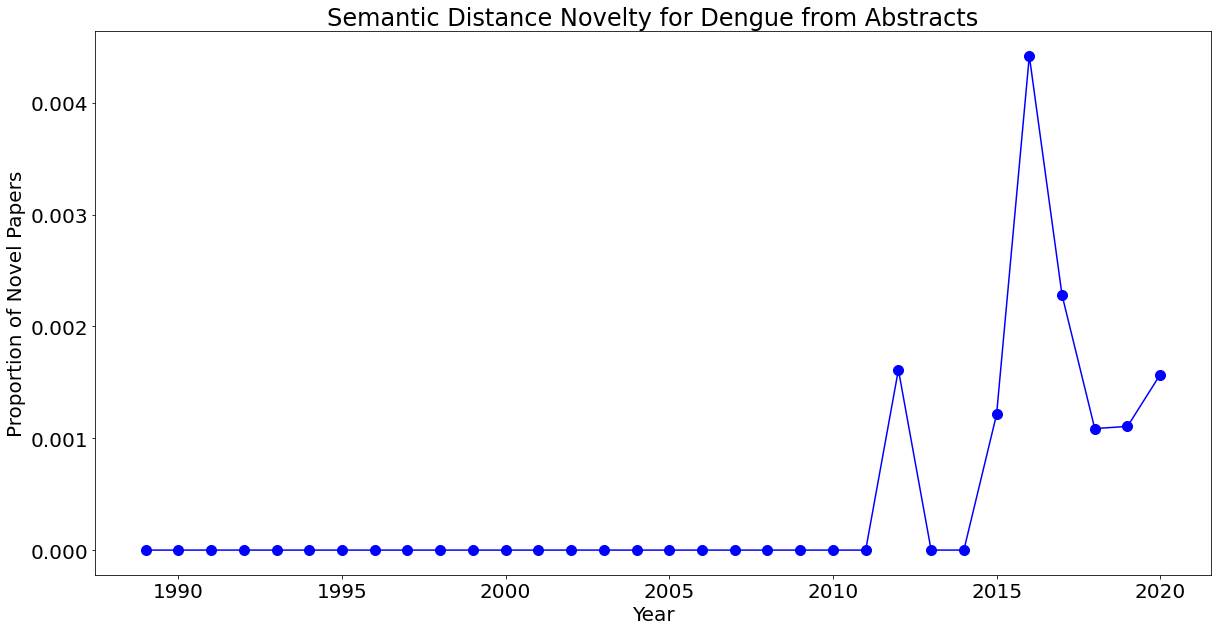

In [36]:
plt.figure(figsize=(20, 10))
plt.scatter(year_span[1:], counts, color='b', s=100)
plt.plot(year_span[1:], counts, color='b')
plt.title(f'Semantic Distance Novelty for {term} from Abstracts')
plt.xlabel('Year')
plt.ylabel('Proportion of Novel Papers')
plt.rc('font', size=20)
plt.show()

### Identify clusters of novel research based on paper abstracts

In [37]:
# identify research papers published between year CHANGEPOINT and CHANGEPOINT + DELTA,  such that
# (the mean distance between the paper abstract and its K nearest neighbors published before week CHANGEPOINT)
# is at least RATIO_THRESHOLD times (the mean distance between the paper abstract and its K nearest neighbors
# also published between CHANGEPOINT and CHANGEPOINT + DELTA)
CHANGEPOINT = 2000
K = 3
DELTA = 5
RATIO_THRESHOLD = 1.2

In [38]:
abstracts_old, abstract_vectors_old, years_old = [], [], []
abstracts_new, abstract_vectors_new, years_new, titles_new = [], [], [], []

for abstract, abstract_vector, year in zip(abstracts, abstract_vectors, years):
    if year < CHANGEPOINT:
        abstracts_old.append(abstract)
        abstract_vectors_old.append(abstract_vector)
        years_old.append(year)
    if year >= CHANGEPOINT and year <= CHANGEPOINT + DELTA:
        abstracts_new.append(abstract)
        abstract_vectors_new.append(abstract_vector)
        years_new.append(year)
        titles_new.append(title)
            
for abstract, abstract_vector, year, title in zip(abstracts_new, abstract_vectors_new, years_new, titles_new):
    new_distance = np.mean(sorted([dist(abstract_vector, t_v) for t_v in abstract_vectors_new])[1:][:K])
    old_distance = np.mean(sorted([dist(abstract_vector, t_v) for t_v in abstract_vectors_old])[:K])
    
    if (old_distance / new_distance) > RATIO_THRESHOLD:
        print(f'Year: {year}')
        print(f'Ratio: {old_distance / new_distance}')
        print(f'New Distance: {new_distance}')
        print(f'Old Distance: {old_distance}')
        print(f'Title: {title}')
        print()

Year: 2005
Ratio: 1.2066296339035034
New Distance: 1.550586223602295
Old Distance: 1.8709832429885864
Title: Alpha-glucosidase inhibitors reduce dengue virus production by affecting the initial steps of virion morphogenesis in the endoplasmic reticulum.

Year: 2005
Ratio: 1.3255099058151245
New Distance: 1.6203864812850952
Old Distance: 2.1478383541107178
Title: Alpha-glucosidase inhibitors reduce dengue virus production by affecting the initial steps of virion morphogenesis in the endoplasmic reticulum.

Year: 2005
Ratio: 1.2304691076278687
New Distance: 1.4757214784622192
Old Distance: 1.8158296346664429
Title: Alpha-glucosidase inhibitors reduce dengue virus production by affecting the initial steps of virion morphogenesis in the endoplasmic reticulum.

Year: 2005
Ratio: 1.295111060142517
New Distance: 1.2600386142730713
Old Distance: 1.6318899393081665
Title: Alpha-glucosidase inhibitors reduce dengue virus production by affecting the initial steps of virion morphogenesis in the en

### Create differential wordclouds for paper abstracts

In [39]:
# creates a differential wordcloud for words appearing in year2, vs all words appearing before or during year1
def create_wordcloud(year1, year2):
    freqs_prev = np.sum(v[years <= year1], axis=0) / np.sum(years <= year1)
    freqs_new = np.sum(v[years == year2], axis=0) / np.sum(years == year2)

    diffs = np.subtract(freqs_prev, freqs_new)

    pos_features, neg_features = set(), set()

    d = {}
    for diff, feature in zip(diffs, features_unsorted):
        if feature in stop_words:
            continue

        diff = round(diff * 1000)
        if diff > 0:
            d[feature] = diff
            pos_features.add(feature)
        if diff < 0:
            neg_features.add(feature) 
            d[feature] = -diff

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word in pos_features:
            return "rgb(0, 0, 0)"
        if word in neg_features:
            return "rgb(256, 0, 0)"

    wordcloud = WordCloud(background_color='white', height=500, width=1000)
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3),
               interpolation="bilinear")
    plt.axis("off")
    plt.show()

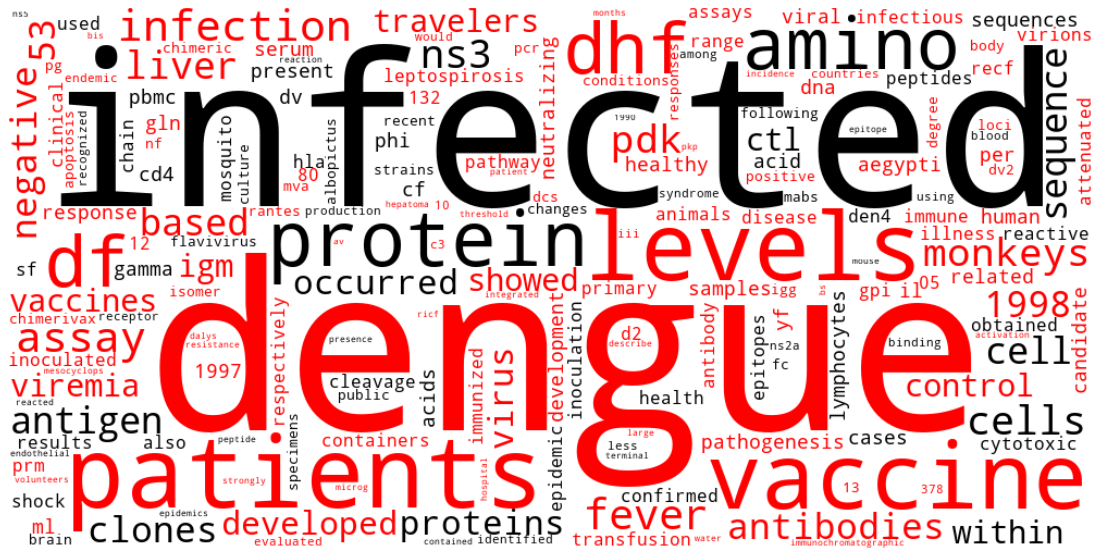

In [40]:
create_wordcloud(1999, 2000)